## 3 - Working with Points

In this notebook, we will explore GPlately functionalities for working with point data. Here, we detail how GPlately's `Points` object can be used to:

- Reconstruct seed point motion paths through geological time; and
- Obtain point velocity data

GPlately's `Points` object works using a plate motion model made from the `PlateReconstruction` object.

Let's first initialise all needed packages.

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Before we proceed, we'll need to create a plate motion model. You can do this easily with GPlately's `PlateReconstruction` object. All you need to do is define a path to a rotation file, topology features and some static polygons and pass these into the object.

We'll use Muller et al. (2019) data downloaded on-the-fly into your local cache with GPlately's `DataServer` object. Let's call the object `gfetch`. 

In [2]:
# Initialise gplately data server
gfetch = gplately.data.DataServer()

# We want Muller et al. (2019) data
zip_url = "https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_PlateMotionModel/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics.zip"

# Get the rotation model and topologies 
rot_ext = ".rot"
rotation_filenames = gfetch.fetch_filenames(zip_url, rot_ext)
rotation_model = pygplates.RotationModel(rotation_filenames)

gpml_ext = ".gpml"
topology_filenames = gfetch.fetch_filenames(zip_url, gpml_ext)
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

# Get the static polygons
stat_poly_ext = ".shp"
static_polygons = gfetch.fetch_static_polygons(zip_url, stat_poly_ext)

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

### Reconstructing motion paths

We just used the `PlateReconstruction` object to create our plate motion model. Now we can look at the `Points` object which can be used to reconstruct motion paths from point data. A motion path is a trail that a reconstructed seed point on a plate follows through geological time relative to some other plate or frame of reference. 

As an example, let's examine the convergence of the Indian Craton (assigned plate ID 501) with the Eurasian Plate (assigned plate ID 301) over 150 Ma. We focus on a single seed point atop plate 501 (with lat=30 and lon=78 degrees) and map out its motion path relative to plate 301.

To reconstruct a motion path with GPlately's `Points` object, all you need to supply is the plate motion model you created with the `PlateReconstruction` object. Next, you'll need a numpy array of point latitudes and a numpy array of point longitudes of the point(s) whose motion paths you want to reconstruct.

To model the motion of our single seed point on the Indian craton, let's define its latitude and longitude in a numpy array and call the `Points` object.

In [3]:
# Longitude and latitude of the single seed point
pt_lon = np.array([78.])
pt_lat = np.array([30.])

# Call the Points object!
gpts = gplately.Points(model, pt_lon, pt_lat)

Now, we can use the `reconstruct` module to create this seed point's motion path. Let's map out its movement relative to plate 301 (the Eurasian Plate) over 150 Ma in 1-million year intervals.

In [4]:
# Motion path variables
oldest_reconstruction_time = 150
anchor_plate_id = 301
moving_plate = 501

# Arrays to fill with reconstructed points
rlons = np.empty((oldest_reconstruction_time, pt_lon.size))
rlats = np.empty((oldest_reconstruction_time, pt_lon.size))

# Reconstruct the seed point's position every millionth year
time_array = range(0, oldest_reconstruction_time)
for time in time_array:
    rlons[time], rlats[time] = gpts.reconstruct(time, anchor_plate_id)

You can visualise a seed-point motion path on a map using GPlately's `PlotTopologies` object. To call it, you just need to supply the plate motion model created using the `PlateReconstruction` object, and a reconstruction time for plotting. Let's set `time = 0` so that we can visualise our motion path on a present-day Earth.

Other parameters you need for `PlotTopologies` are paths to coastline, continent and continent-ocean boundary (COB) files. Here, we provide Muller et al. (2019) shapefiles using GPlately's `DataServer` object. 

In [5]:
# Obtain geometry shapefiles with fetcher
zip_url = "https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_PlateMotionModel/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics.zip"
shp_ext = ".shp"
coastlines = gfetch.fetch_coastlines(zip_url, shp_ext)
continents = gfetch.fetch_continents(zip_url, shp_ext)
COBs = gfetch.fetch_COBs(zip_url, shp_ext)

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Let's use `PlotTopologies` to map out this motion path!

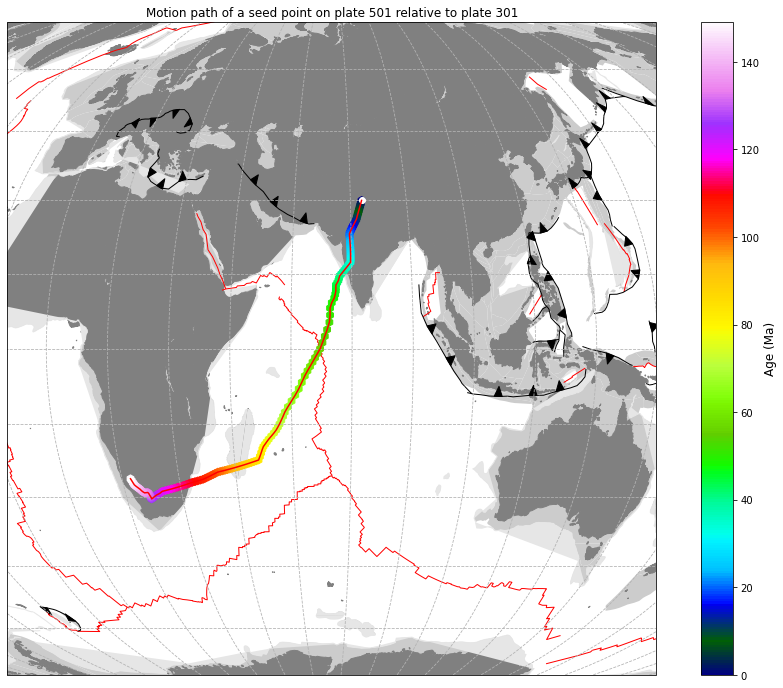

In [6]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 70))
ax2.set_extent([-10, 150, -30, 30])
ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Motion path of a seed point on plate %i relative to plate %i' % (moving_plate, anchor_plate_id))

# Plot shapefile features, subduction zones and MOR boundaries at present day
gplot.plot_continents(ax2, facecolor='0.8')
gplot.plot_coastlines(ax2, color='0.5')
gplot.plot_continent_ocean_boundaries(ax2, color='0.9')
gplot.plot_ridges_and_transforms(ax2, color='red')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k')

# Plot the seed point's locations every Ma through geological time
l1=ax2.scatter(rlons, rlats, 60, c=time_array, marker='h',
                          cmap=plt.cm.gist_ncar, transform=ccrs.PlateCarree(), zorder=2)

# Highlight the seed point's motion path as well as its position at the start and end of the reconstruction time
ax2.plot(rlons[0],rlats[0],'wo', transform=ccrs.PlateCarree(), zorder=2)
ax2.plot(rlons[-1],rlats[-1],'wo', transform=ccrs.PlateCarree(), zorder=2)
ax2.plot(rlons,rlats,'r', transform=ccrs.PlateCarree())

# If you want to show the full globe, you must set global extent
#ax2.set_global()

# Create a color bar
fig.colorbar(l1, ax=ax2, shrink=1).set_label('Age (Ma)',fontsize=12)

### Obtaining velocity data

GPlately's `Points` object can also be used to obtain point velocity data. Specifically, it calculates the x (North) and y (East) Cartesian components of plate velocity (which is represented in north/east/down coordinates) at a specific geological time. We can calculate overall velocity magnitudes using the hypotenuse of these components.

Let's find our seed point's velocity at every millionth year through its movement over 150 Ma.

In [7]:
# Arrays to fill with seed point velocity data
vel_x = np.empty((oldest_reconstruction_time, pt_lon.size))
vel_y = np.empty((oldest_reconstruction_time, pt_lon.size))
vel_mag = np.empty((oldest_reconstruction_time, pt_lon.size))

# Obtain x and y components of north/east/down velocity at each Ma for 150 Ma
for time in time_array:
    vel_x[time], vel_y[time] = gpts.plate_velocity(time)
    vel_mag[time] = np.hypot(vel_x[time], vel_y[time])

Below we plot the average velocity (cm/yr) of the Indian craton (plate 501) from 150 Ma years ago to present day. Currently, the Indian plate is moving north-east at around 5 cm/yr!

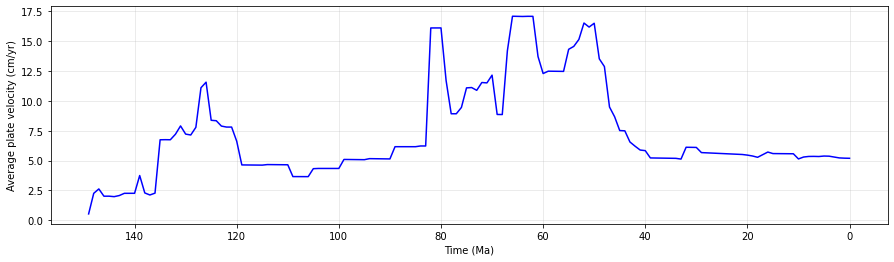

At time = 0.00 Ma
Reconstructed Seed Point Lat = 30.000000, Lon = 78.000000
Plate velocity magnitude = 5.1935 cm/yr


In [8]:
# Show plot of average plate velocity mag (cm/yr) at each millionth year b/w 0-150 Ma
fig2 = plt.figure(figsize=(15,4))
plt.plot(time_array,vel_mag, color='b')
plt.xlabel('Time (Ma)')
plt.ylabel('Average plate velocity (cm/yr)')
plt.gca().invert_xaxis()
plt.grid(alpha=0.3)
plt.show()

# Extract details of seed point at present day
print('At time = %0.2f Ma' % (time_array[0]))
print('Reconstructed Seed Point Lat = %f, Lon = %f' % (rlats[0], rlons[0]))
print('Plate velocity magnitude = %0.4f cm/yr' % (vel_mag[0]))